In [5]:
# import python module
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib as mpl
from cycler import cycler
import pandas as pd

In [6]:
## Phosphorus Cycle
def Mop(Fwp, Fbp):
    '''Mass of phosphate in the oceans
    Fwp : Flux of phosphate into the oceans
    Pbp : flux of phosphate out of the oceans due to burial
    '''
    y = (Fwp - Fbp)
    return y
def Fwp(weatherability, ClimateWeatheringFactor):
    '''
    Flux of phosphate to the oceans (10^12 mol per ky)
    '''
    y = 30 * weatherability * ClimateWeatheringFactor
    return y
def Fbp(Mop, Mop_initial):
    '''Burial of phosphate
    Mop : mass of phosphatein the ocean
    Mop_initial : initial Mop set to 3e3 x 10e12 mol/myr
    '''
    y = 30 * (Mop / Mop_initial)
    return y

## Carbon Cycle
def Moc(Fworg, Fvolc, Fborg, Fwsil):
    ''' Mass of Carbon in the atmosphere ocean system'''
    y = (Fworg + Fvolc - Fborg - Fwsil)
    return y
    
def Fworg(weatherability, ClimateWeatheringFactor):
    '''Weathering of organic matter'''
    y = 1e4 * weatherability * ClimateWeatheringFactor
    return y
def Fborg(Fbp, CtoP=333):
    '''Burial of organic matter
    Fbp : Flux of phosphate burial
    CtoP : Carbon to Phosphorus ratio (333)
    '''
    y = Fbp * CtoP
    return y
def Fwsil(weatherability, ClimateWeatheringFactor):
    '''Silicate weathering flux'''
    y = 6e3 * weatherability * ClimateWeatheringFactor
    return y

## Strontium Cycle
def Ro(ro, rb, rr, Fwsr, jhsl, Mosr):
    '''Isotopic mass balance of strontium'''
    y = (((1+ro)/(1+rb)) * (rr-ro) * Fwsr + ((1+ro)/(1+rb)) * (rb-ro) * jhsl) / (Mosr)
    return y
def Rr(time, weatherability):
    '''Sr ratios of riverine flux'''
    if time < 2e4:
        y = 0.7119 - time * 1e-8
    else:
        y = (0.7117 + (weatherability - 1) * 0.7033) / (weatherability)
    return y
def Fwsr(weatherability, climateweatheringfactor):
    '''Riverine Sr flux (continental)'''
    y = 30 * weatherability * climateweatheringfactor
    return y

## PCO2 and Climate Weathering Factor
def pCO2(Moc, Moc_0=1.61e7, pCO2_0=5000):
    '''Partial pressure of CO2'''
    y = (Moc / Moc_0)**2 * pCO2_0
    return y
def CWF(pCO2, p=0.3,pCO2_0=5000):
    '''Climate Weathering Factor'''
    y = (pCO2/pCO2_0)**p
    return y

# load sea level data
ordosealevel = np.load("../Data/OrdoSeaLevel.npz")['SeaLevel']
ordoseaage = np.load("../Data/OrdoSeaLevel.npz")['age']


def runmod(x_weath, x_cw):
    dt = 1
    # time
    time_min = 0
    time_max = 40000
    time = np.arange(time_min, time_max, dt)
    # array size
    t = len(time)
    age = 484 - time/1e3

    #set time and rate of weatherability change
    rise_start = np.where(np.round(age)==462)[0][0]     #statement looks up timestep closest to specified age, e.g. 463 Ma
    rise_stop = np.where(np.round(age)==455)[0][0]      #original Young model has rise start at 463, stop 459, fall 447, stop 443
    fall_start = np.where(np.round(age)==453)[0][0]
    # Weatherability
    W = np.ones(t)
    W[rise_start:rise_stop] = np.linspace(1.0, x_weath, (rise_stop-rise_start))
    W[rise_stop:] = x_weath

    # pCO2
    pco2= np.ones(t) # array for pCO2
    pco2_0 = 5000     # initial value of pCO2
    pco2[0] = pco2_0

    # Climate Weathering Factor (CWP)
    cwf = np.ones(t)
    cwf[0] = CWF(pco2[0], p=x_cw)
    
    # resample data to fit our modeling array
    from scipy import interpolate
    f = interpolate.interp1d(ordoseaage, ordosealevel)
    sealevel = f(age)

    # normalize sea level relative to mean
    sl_norm = sealevel / sealevel.mean()
    
    Jh_sl = sl_norm * 2e1
    
    # Initialize Fvolc; also tuning volc flux
    fvolc = np.ones(t)
    fvolc = (sl_norm) * 6000 # initial value = 6000 (Kump and Arthur, 1999)
    
    #Initialize arrays for diff.eq #1
    mop = np.ones(t)  # array for Mop
    mop_0 = 3e3       # initial value of Mop
    mop[0] = mop_0    # assign initial value into array

    fwp = Fwp(W, cwf)     # initiate array for phosphorus flux
    fbp = Fbp(mop, mop_0) # initiate array for phosphorus burial

    # Initialize arrays for diff.eq #2
    moc = np.ones(t)  # array for Moc
    moc_0 = 1.61e7    # initial value of Moc
    moc[0] = moc_0    # assign initial value into array

    fworg = Fworg(W, cwf)
    fborg = Fborg(fbp)
    fwsil = Fwsil(W, cwf)
    
    # Initialize Mosr
    mosr = np.ones(t) * 12.4e4

    # Initialize arrays for diff.eq #3
    ro = np.ones(t)
    ro_0 = 0.7091
    ro[0] = ro_0

    rb = np.ones(t) * 0.7033
    fhyd = np.ones(t) * 1.75e-3

    rr = np.ones(t) * 0.7106
    rr[0] = Rr(time[0], W[0])

    fwsr = np.ones(t)
    fwsr[0] = Fwsr(W[0], cwf[0])
    
    # Model implementation
    for i in range(t-1):

        fworg[i+1] = Fworg(W[i], cwf[i])
        fborg[i+1] = Fborg(fbp[i])
        fwsil[i+1] = Fwsil(W[i], cwf[i])
        moc[i+1] = moc[i] + dt*Moc(fworg[i], fvolc[i], fborg[i], fwsil[i])

        pco2[i+1] = pCO2(moc[i], moc_0, pco2_0)
        cwf[i+1] = CWF(pco2[i], p=x_cw)

        fwp[i+1] = Fwp(W[i], cwf[i])
        fbp[i+1] = Fbp(mop[i], mop_0)
        mop[i+1] = mop[i] + dt*Mop(fwp[i],fbp[i])

        rr[i+1] = Rr(time[i], W[i])
        fwsr[i+1] = Fwsr(W[i], cwf[i])
        ro[i+1] = ro[i] + dt*Ro(ro[i], rb[i], rr[i], fwsr[i], Jh_sl[i], mosr[i])
    
    results = {'age': age,
               'W': cwf,
               'fwsil' : fwsil,
               'pco2': pco2,
               'fvolc':fvolc,
               'fwsr':fwsr,
               'ro': ro,
               'friv':fwsr}
    return results  

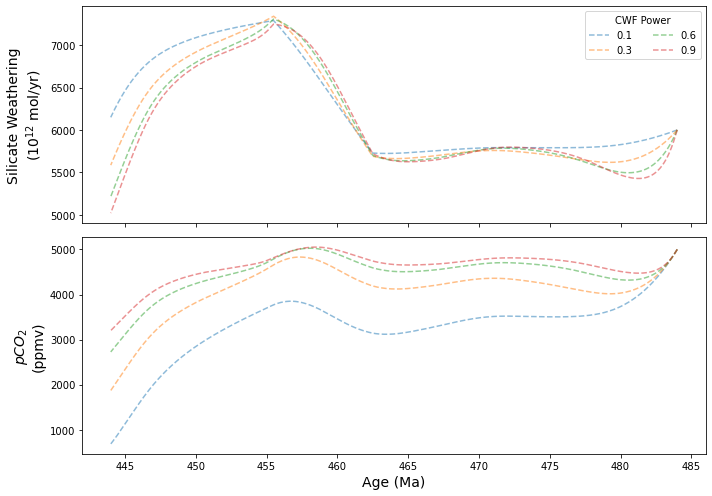

In [11]:
# Weatherability increases by 25%, CWF exponent vary

res_base3 = runmod(1.25, 0.3)
res_base1 = runmod(1.25, 0.1)
res_base6 = runmod(1.25, 0.6)
res_base9 = runmod(1.25, 0.9)

res_all = [res_base1, res_base3, res_base6, res_base9]
lab = ['0.1', '0.3', '0.6', '0.9']

# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,7))

for r, l in zip(res_all, lab):
    ax1.plot(r['age'], r['fwsil'], label=l,ls='--', alpha=0.5)
    ax2.plot(r['age'], r['pco2'], ls='--', alpha=0.5)

ax1.set_ylabel('Silicate Weathering\n($10^{12} $ mol/yr)', fontsize=14)
ax2.set_ylabel('$pCO_2$\n(ppmv)', fontsize=14)
ax1.legend(ncol=2, title='CWF Power')
ax2.set_xlabel('Age (Ma)', fontsize=14)

plt.tight_layout()
plt.savefig('../Figures/CWF_Sensitivity.jpg', dpi=300)
plt.savefig('../Figures/CWF_Sensitivity.svg')

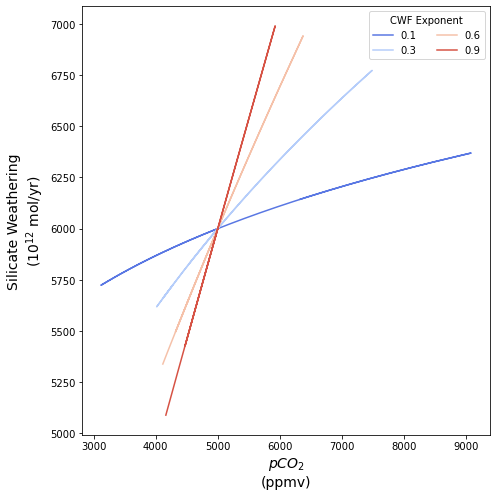

In [23]:
# constant weatherability, varying CWF

res_const_w_1 = runmod(1.0, 0.1)
res_const_w_3 = runmod(1.0, 0.3)
res_const_w_6 = runmod(1.0, 0.6)
res_const_w_9 = runmod(1.0, 0.9)

res_all_w = [res_const_w_1, res_const_w_3, res_const_w_6, res_const_w_9]
lab = ['0.1', '0.3', '0.6', '0.9']

fig, ax = plt.subplots(figsize=(7,7))

# Change color cycle to coolwarm
color = plt.cm.coolwarm(np.linspace(0.1,0.9,4))
ax.set_prop_cycle(cycler('color', color))

for r, l in zip(res_all_w, lab):
    ax.plot(r['pco2'], r['fwsil'], label=l)

ax.set_ylabel('Silicate Weathering\n($10^{12} $ mol/yr)', fontsize=14)
ax.set_xlabel('$pCO_2$\n(ppmv)', fontsize=14)
ax.legend(ncol=2, title='CWF Exponent')

plt.tight_layout()
plt.savefig('../Figures/CWF_Sensitivity_xplot.jpg', dpi=300)
plt.savefig('../Figures/CWF_Sensitivity_xplot.svg')

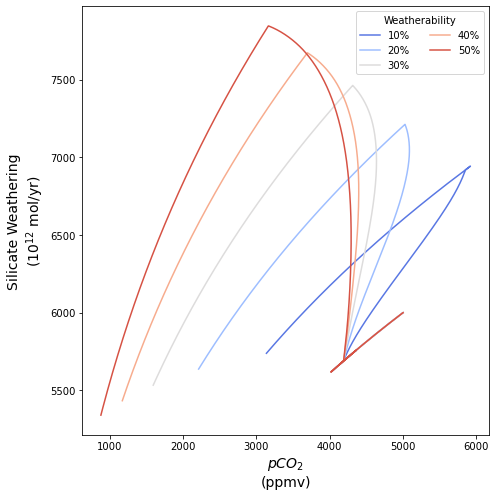

In [9]:
# constant CWF, varying weatherability

res_const_cwf_1 = runmod(1.1, 0.3)
res_const_cwf_2 = runmod(1.2, 0.3)
res_const_cwf_3 = runmod(1.3, 0.3)
res_const_cwf_4 = runmod(1.4, 0.3)
res_const_cwf_5 = runmod(1.5, 0.3)

res_all_cwf = [res_const_cwf_1, res_const_cwf_2, res_const_cwf_3,
               res_const_cwf_4, res_const_cwf_5]
lab2 = ['10%', '20%', '30%', '40%', '50%']

fig, ax = plt.subplots(figsize=(7,7))

# Change color cycle to coolwarm
color = plt.cm.coolwarm(np.linspace(0.1,0.9,5))
ax.set_prop_cycle(cycler('color', color))

for r, l in zip(res_all_cwf, lab2):
    ax.plot(r['pco2'], r['fwsil'], label=l)

ax.set_ylabel('Silicate Weathering\n($10^{12} $ mol/yr)', fontsize=14)
ax.set_xlabel('$pCO_2$\n(ppmv)', fontsize=14)
ax.legend(ncol=2, title='Weatherability')

plt.tight_layout()
plt.savefig('../Figures/weatherability_Sensitivity_xplot.jpg', dpi=300)
plt.savefig('../Figures/weatherability_Sensitivity_xplot.svg')

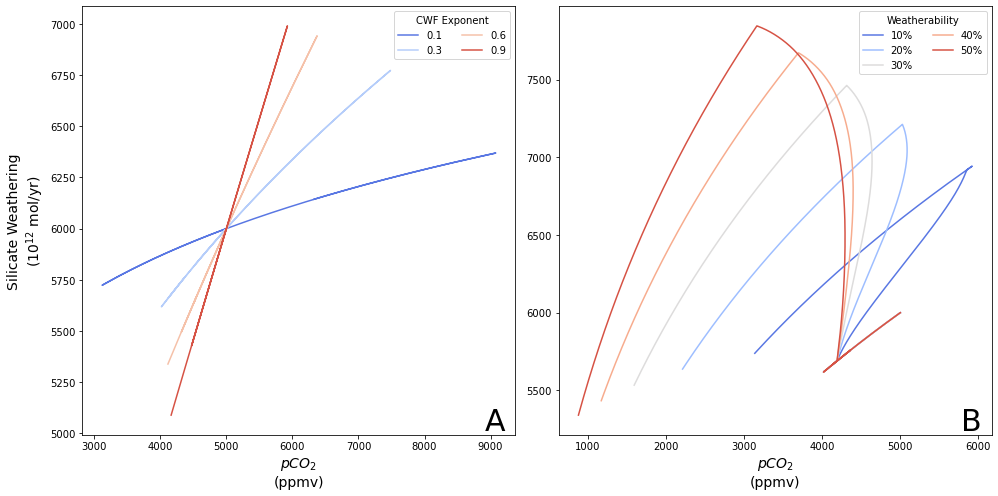

In [22]:
# Combining both xplots
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14, 7))

color = plt.cm.coolwarm(np.linspace(0.1,0.9,4))
ax1.set_prop_cycle(cycler('color', color))

color = plt.cm.coolwarm(np.linspace(0.1,0.9,5))
ax2.set_prop_cycle(cycler('color', color))

for r, l in zip(res_all_w, lab):
    ax1.plot(r['pco2'], r['fwsil'], label=l)

ax1.set_ylabel('Silicate Weathering\n($10^{12} $ mol/yr)', fontsize=14)
ax1.set_xlabel('$pCO_2$\n(ppmv)', fontsize=14)
ax1.legend(ncol=2, title='CWF Exponent')

for r, l in zip(res_all_cwf, lab2):
    ax2.plot(r['pco2'], r['fwsil'], label=l)

ax2.set_xlabel('$pCO_2$\n(ppmv)', fontsize=14)
ax2.legend(ncol=2, title='Weatherability')

for ax, f in zip([ax1,ax2], ['A', 'B']):
    ax.text(0.93, 0.01, f, fontsize=30, transform=ax.transAxes)

plt.tight_layout()
plt.savefig('../Figures/weathering_Curve_Sensitivity.jpg', dpi=300)
plt.savefig('../Figures/weathering_Curve_Sensitivity.svg')